In [24]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin, unquote  # Add unquote
import re  # Import the regular expression module

from pathlib import Path

import pandas as pd
import os
import json
from src.utils import save_data, download_file  # Import download_file
from src.config import TARGET_URL, OUTPUT_FILE, DOWNLOAD_DIR, mapping_post_country

In [3]:
# 1. Obter o HTML
url = TARGET_URL
try:
    response = requests.get(url)
    response.raise_for_status()  # Lança uma exceção se a requisição falhar
    html_content = response.text
except requests.exceptions.RequestException as e:
    print(f"Erro ao obter a página: {e}")
    exit()  # Ou outro tratamento de erro

In [4]:
# 2. Analisar o HTML
soup = BeautifulSoup(html_content, 'html.parser')  # Ou 'lxml', se tiver instalado

file_links = []

for a_tag in soup.find_all('a'):  # Find all <a> tags
    href = a_tag.get('href')
    if href and href.lower().endswith('.xlsx'):  # Check if href exists and ends with .pdf / .xlsx (case-insensitive)
        file_links.append(href)

# return pdf_links
file_links[-5:]



['/content/dam/visas/Statistics/Non-Immigrant-Statistics/MonthlyNIVIssuances/Excel/FY2025/NOVEMBER%202024%20-%20NIV%20Issuances%20by%20Post%20and%20Visa%20Class.xlsx',
 '/content/dam/visas/Statistics/Non-Immigrant-Statistics/MonthlyNIVIssuances/Excel/FY2025/DECEMBER%202024%20-%20NIV%20Issuances%20by%20Nationality%20and%20Visa%20Class.xlsx',
 '/content/dam/visas/Statistics/Non-Immigrant-Statistics/MonthlyNIVIssuances/Excel/FY2025/DECEMBER%202024%20-%20NIV%20Issuances%20by%20Post%20and%20Visa%20Class.xlsx',
 '/content/dam/visas/Statistics/Non-Immigrant-Statistics/MonthlyNIVIssuances/Excel/FY2025/JANUARY%202025%20-%20NIV%20Issuances%20by%20Nationality%20and%20Visa%20Class.xlsx',
 '/content/dam/visas/Statistics/Non-Immigrant-Statistics/MonthlyNIVIssuances/Excel/FY2025/JANUARY%202025%20-%20NIV%20Issuances%20by%20Post%20and%20Visa%20Class.xlsx']

In [5]:
# 3. Encontrar e Extrair Dados
structured_data = {}
# base_url = url
for link in file_links:
    # 1. Remove the base URL and decode URL encoding
    absolute_url = urljoin("https://travel.state.gov/", link)
    relative_path = absolute_url.replace(url, "").strip("/")  # Remove base and leading/trailing slashes
    relative_path = unquote(relative_path)  # Decode %20 to spaces, etc.
    

    # 2. Extract year, month, and type using regular expressions
    match = re.match(r'.*/FY(\d{4})/(\w+)\s*(\d{4}).*-\s*(.*?)\.xlsx', relative_path, re.IGNORECASE)


    if match:
        fiscal_year_str, month_str, year_str, report_type = match.groups()
        fiscal_year = int(fiscal_year_str)
        year = int(year_str)
        month = month_str.upper()
        date = f"{month} {year}"  # Combine month and year
        report_type = report_type.strip() # Remove extra spaces


        if fiscal_year not in structured_data:
            structured_data[fiscal_year] = {}
        if date not in structured_data[fiscal_year]:
            structured_data[fiscal_year][date] = {}  # Use date as the key
        if "reports" not in structured_data[fiscal_year][date]:
            structured_data[fiscal_year][date]["reports"] = []

        structured_data[fiscal_year][date]["reports"].append({
            "report_type": report_type,
            "url": absolute_url
        })

    else:
        print(f"Warning: Could not parse URL: {link}")

    # return structured_data
structured_data

{2023: {'OCTOBER 2022': {'reports': [{'report_type': 'NIV Issuances by Nationality and Visa Class',
     'url': 'https://travel.state.gov/content/dam/visas/Statistics/Non-Immigrant-Statistics/MonthlyNIVIssuances/Excel/FY2023/OCTOBER%202022%20-%20NIV%20Issuances%20by%20Nationality%20and%20Visa%20Class.xlsx'},
    {'report_type': 'NIV Issuances by Post and Visa Class',
     'url': 'https://travel.state.gov/content/dam/visas/Statistics/Non-Immigrant-Statistics/MonthlyNIVIssuances/Excel/FY2023/OCTOBER%202022%20-%20NIV%20Issuances%20by%20Post%20and%20Visa%20Class.xlsx'}]},
  'NOVEMBER 2022': {'reports': [{'report_type': 'NIV Issuances by Nationality and Visa Class',
     'url': 'https://travel.state.gov/content/dam/visas/Statistics/Non-Immigrant-Statistics/MonthlyNIVIssuances/Excel/FY2023/NOVEMBER%202022%20-%20NIV%20Issuances%20by%20Nationality%20and%20Visa%20Class.xlsx'},
    {'report_type': 'NIV Issuances by Post and Visa Class',
     'url': 'https://travel.state.gov/content/dam/visas/Sta

In [8]:
# 4. Estruturar e Imprimir/Salvar os Dados
all_dataframes = []
for fiscal_year, year_data in structured_data.items():
    for date, date_data in year_data.items():
        for report_info in date_data["reports"]:
            report_type = report_info["report_type"]
            url = report_info["url"]

            # Construct a filename (you might need to adjust this)
            filename = f"{fiscal_year}_{date}_{report_type.replace(' ', '_')}.xlsx"
            filepath = Path(DOWNLOAD_DIR) / filename

            # Download the file
            if download_file(url, filepath):
                try:
                    # Read the Excel file into a pandas DataFrame
                    df = pd.read_excel(filepath, header=1, skipfooter=1)

                    # Add metadata columns
                    df["Fiscal Year"] = fiscal_year
                    df["Date"] = date
                    df["Report Type"] = report_type
                    df["Source URL"] = url

                    all_dataframes.append(df)
                except Exception as e:
                    print(f"Error reading or processing {filepath}: {e}")
            else:
                print(f"Failed to download {url}")

In [10]:
# fiscal_year = {2024, 2025}
fiscal_year = 2024
# report_type = "NIV Issuances by Nationality and Visa Class"
report_type = "NIV Issuances by Post and Visa Class"
all_dataframes = []
year_data = structured_data[fiscal_year]

for year, year_data in structured_data.items():
        if fiscal_year is not None and year != fiscal_year:
            continue  # Skip this year if it doesn't match the requested year
        
        for date, date_data in year_data.items():
          for report_info in date_data["reports"]:
              current_report_type = report_info["report_type"]
              url = report_info["url"]

              # Filter by report_type (case-insensitive)
              if report_type is not None and report_type.lower() not in current_report_type.lower():
                  continue  # Skip this report if it doesn't match

              filename = f"{fiscal_year}_{date}_{report_type.replace(' ', '_')}.xlsx"
              filepath = Path(DOWNLOAD_DIR) / filename
              filepath_str = str(filepath)

              if download_file(url, filepath_str):
                  try:
                      print(f"Attempting to read Excel file from: {filepath_str}")
                      df = pd.read_excel(filepath_str, header=1, skipfooter=1)
                      df["Fiscal Year"] = fiscal_year
                      df["Date"] = date
                      df["Report Type"] = report_type
                      df["Source URL"] = url
                      all_dataframes.append(df)
                  except Exception as e:
                      print(f"Error reading or processing {filepath_str}: {e}")
              else:
                  print(f"Failed to download {url}, skipping processing.")

Attempting to read Excel file from: data\downloads\2024_OCTOBER 2023_NIV_Issuances_by_Post_and_Visa_Class.xlsx
Attempting to read Excel file from: data\downloads\2024_NOVEMBER 2023_NIV_Issuances_by_Post_and_Visa_Class.xlsx
Attempting to read Excel file from: data\downloads\2024_DECEMBER 2023_NIV_Issuances_by_Post_and_Visa_Class.xlsx
Attempting to read Excel file from: data\downloads\2024_JANUARY 2024_NIV_Issuances_by_Post_and_Visa_Class.xlsx
Attempting to read Excel file from: data\downloads\2024_FEBRUARY 2024_NIV_Issuances_by_Post_and_Visa_Class.xlsx
Attempting to read Excel file from: data\downloads\2024_MARCH 2024_NIV_Issuances_by_Post_and_Visa_Class.xlsx
Attempting to read Excel file from: data\downloads\2024_APRIL 2024_NIV_Issuances_by_Post_and_Visa_Class.xlsx
Attempting to read Excel file from: data\downloads\2024_MAY 2024_NIV_Issuances_by_Post_and_Visa_Class.xlsx
Attempting to read Excel file from: data\downloads\2024_JUNE 2024_NIV_Issuances_by_Post_and_Visa_Class.xlsx
Attemptin

In [15]:
# report_type = "NIV Issuances by Nationality and Visa Class"
report_type = "NIV Issuances by Post and Visa Class"
all_dataframes = []

for fiscal_year, year_data in structured_data.items():
    for date, date_data in year_data.items():
        for report_info in date_data["reports"]:
            report_type = report_info["report_type"]
            url = report_info["url"]

            # Filter by report_type (case-insensitive)
            if report_type is not None and report_type.lower() not in current_report_type.lower():
                continue  # Skip this report if it doesn't match

            # Construct a filename (you might need to adjust this)
            filename = f"{fiscal_year}_{date}_{report_type.replace(' ', '_')}.xlsx"
            filepath = Path(DOWNLOAD_DIR) / filename

            # Download the file
            if download_file(url, filepath):
                try:
                    # Read the Excel file into a pandas DataFrame
                    df = pd.read_excel(filepath, header=1, skipfooter=1)

                    # Add metadata columns
                    df["Fiscal Year"] = fiscal_year
                    df["Date"] = date
                    df["Report Type"] = report_type
                    df["Source URL"] = url

                    all_dataframes.append(df)
                except Exception as e:
                    print(f"Error reading or processing {filepath}: {e}")
            else:
                print(f"Failed to download {url}")

In [16]:
dfs = pd.concat(all_dataframes, ignore_index=True)
dfs

,Post,Visa Class,Issuances,Fiscal Year,Date,Report Type,Source URL
0,Abidjan,A1,1,2023,OCTOBER 2022,NIV Issuances by Post and Visa Class,https://travel.state.gov/content/dam/visas/Sta...
1,Abidjan,A2,34,2023,OCTOBER 2022,NIV Issuances by Post and Visa Class,https://travel.state.gov/content/dam/visas/Sta...
2,Abidjan,B1,5,2023,OCTOBER 2022,NIV Issuances by Post and Visa Class,https://travel.state.gov/content/dam/visas/Sta...
3,Abidjan,B1/B2,623,2023,OCTOBER 2022,NIV Issuances by Post and Visa Class,https://travel.state.gov/content/dam/visas/Sta...
4,Abidjan,C1,1,2023,OCTOBER 2022,NIV Issuances by Post and Visa Class,https://travel.state.gov/content/dam/visas/Sta...
...,...,...,...,...,...,...,...
119988,Zagreb,L2,4,2025,JANUARY 2025,NIV Issuances by Post and Visa Class,https://travel.state.gov/content/dam/visas/Sta...
119989,Zagreb,NATO2,1,2025,JANUARY 2025,NIV Issuances by Post and Visa Class,https://travel.state.gov/content/dam/visas/Sta...
119990,Zagreb,O1,3,2025,JANUARY 2025,NIV Issuances by Post and Visa Class,https://travel.state.gov/content/dam/visas/Sta...
119991,Zagreb,O2,1,2025,JANUARY 2025,NIV Issuances by Post and Visa Class,https://travel.state.gov/content/dam/visas/Sta...


In [ ]:
# enrich with country, based on post
# dfs["Post"].value_counts()
locations_country= {}
for country, value in mapping_post_country.items():
    if isinstance(value, list):
        for loc in value:
            location = loc.get("location").split("(")[0].strip()
            locations_country[location] = country    
    else:
        location = value.get("location").split("(")[0].strip()
        locations_country[location] = country

locations_country

# with open("data/dataframe/post_country.json", "w") as file:
#     json.dump(locations_country, file)

{'Kabul': 'Afghanistan',
 'Tirana': 'Albania',
 'Algiers': 'Algeria',
 'Luanda': 'Angola',
 'Buenos Aires': 'Argentina',
 'Yerevan': 'Armenia',
 'Melbourne': 'Australia',
 'Sydney': 'Australia',
 'Perth': 'Australia',
 'Vienna': 'Austria',
 'Baku': 'Azerbaijan',
 'Nassau': 'Bahamas',
 'Manama': 'Bahrain',
 'Dhaka': 'Bangladesh',
 'Bridgetown': 'Barbados',
 'Minsk': 'Belarus',
 'Brussels': 'Belgium',
 'Belmopan': 'Belize',
 'Cotonou': 'Benin',
 'Hamilton': 'Bermuda',
 'La Paz': 'Bolivia',
 'Sarajevo': 'Bosnia And Herzegovina',
 'Gaborone': 'Botswana',
 'Brasilia': 'Brazil',
 'Rio de Janeiro': 'Brazil',
 'Sao Paulo': 'Brazil',
 'Recife': 'Brazil',
 'Bandar Seri Begawan': 'Brunei',
 'Sofia': 'Bulgaria',
 'Ouagadougou': 'Burkina Faso',
 'Rangoon': 'Burma',
 'Bujumbura': 'Burundi',
 'Phnom Penh': 'Cambodia',
 'Yaounde': 'Cameroon',
 'Ottawa': 'Canada',
 'Calgary': 'Canada',
 'Halifax': 'Canada',
 'Montreal': 'Canada',
 'Quebec': 'Canada',
 'Toronto': 'Canada',
 'Vancouver': 'Canada',
 'Prai

In [ ]:
dfs["Country"] = dfs["Post"].map(locations_country)

dfs['Datetime'] = pd.to_datetime(dfs['Date'], format='%B %Y')
dfs.head()

,Post,Visa Class,Issuances,Fiscal Year,Date,Report Type,Source URL,Country,Datetime
0,Abidjan,A1,1,2023,OCTOBER 2022,NIV Issuances by Post and Visa Class,https://travel.state.gov/content/dam/visas/Sta...,Cote D'ivoire,2022-10-01
1,Abidjan,A2,34,2023,OCTOBER 2022,NIV Issuances by Post and Visa Class,https://travel.state.gov/content/dam/visas/Sta...,Cote D'ivoire,2022-10-01
2,Abidjan,B1,5,2023,OCTOBER 2022,NIV Issuances by Post and Visa Class,https://travel.state.gov/content/dam/visas/Sta...,Cote D'ivoire,2022-10-01
3,Abidjan,B1/B2,623,2023,OCTOBER 2022,NIV Issuances by Post and Visa Class,https://travel.state.gov/content/dam/visas/Sta...,Cote D'ivoire,2022-10-01
4,Abidjan,C1,1,2023,OCTOBER 2022,NIV Issuances by Post and Visa Class,https://travel.state.gov/content/dam/visas/Sta...,Cote D'ivoire,2022-10-01


In [33]:
dfs.to_csv("data/dataframe/all_data.csv")

In [12]:
# ["Brasilia", "Rio de Janeiro", "Sao Paulo", "Recife"]

df_filter = dfs[dfs["Post"].isin(["Brasilia", "Rio de Janeiro", "Sao Paulo", "Recife"])]

print(df_filter["Post"].value_counts())
df_filter

Post
Sao Paulo         385
Rio de Janeiro    365
Brasilia          360
Recife            227
Name: count, dtype: int64


,Post,Visa Class,Issuances,Fiscal Year,Date,Report Type,Source URL
666,Brasilia,A1,7,2024,OCTOBER 2023,NIV Issuances by Post and Visa Class,https://travel.state.gov/content/dam/visas/Sta...
667,Brasilia,A2,188,2024,OCTOBER 2023,NIV Issuances by Post and Visa Class,https://travel.state.gov/content/dam/visas/Sta...
668,Brasilia,B1,75,2024,OCTOBER 2023,NIV Issuances by Post and Visa Class,https://travel.state.gov/content/dam/visas/Sta...
669,Brasilia,B1/B2,13200,2024,OCTOBER 2023,NIV Issuances by Post and Visa Class,https://travel.state.gov/content/dam/visas/Sta...
670,Brasilia,C1/D,24,2024,OCTOBER 2023,NIV Issuances by Post and Visa Class,https://travel.state.gov/content/dam/visas/Sta...
...,...,...,...,...,...,...,...
50770,Sao Paulo,P1,36,2024,SEPTEMBER 2024,NIV Issuances by Post and Visa Class,https://travel.state.gov/content/dam/visas/Sta...
50771,Sao Paulo,P3,13,2024,SEPTEMBER 2024,NIV Issuances by Post and Visa Class,https://travel.state.gov/content/dam/visas/Sta...
50772,Sao Paulo,P4,3,2024,SEPTEMBER 2024,NIV Issuances by Post and Visa Class,https://travel.state.gov/content/dam/visas/Sta...
50773,Sao Paulo,R1,10,2024,SEPTEMBER 2024,NIV Issuances by Post and Visa Class,https://travel.state.gov/content/dam/visas/Sta...


In [13]:
# print(df_filter["Visa Class"].value_counts())

df_filter2 = df_filter[df_filter["Visa Class"] == "L1"]
df_filter2

,Post,Visa Class,Issuances,Fiscal Year,Date,Report Type,Source URL
683,Brasilia,L1,5,2024,OCTOBER 2023,NIV Issuances by Post and Visa Class,https://travel.state.gov/content/dam/visas/Sta...
3248,Recife,L1,11,2024,OCTOBER 2023,NIV Issuances by Post and Visa Class,https://travel.state.gov/content/dam/visas/Sta...
3312,Rio de Janeiro,L1,43,2024,OCTOBER 2023,NIV Issuances by Post and Visa Class,https://travel.state.gov/content/dam/visas/Sta...
3527,Sao Paulo,L1,218,2024,OCTOBER 2023,NIV Issuances by Post and Visa Class,https://travel.state.gov/content/dam/visas/Sta...
4915,Brasilia,L1,6,2024,NOVEMBER 2023,NIV Issuances by Post and Visa Class,https://travel.state.gov/content/dam/visas/Sta...
7408,Recife,L1,10,2024,NOVEMBER 2023,NIV Issuances by Post and Visa Class,https://travel.state.gov/content/dam/visas/Sta...
7465,Rio de Janeiro,L1,33,2024,NOVEMBER 2023,NIV Issuances by Post and Visa Class,https://travel.state.gov/content/dam/visas/Sta...
7665,Sao Paulo,L1,294,2024,NOVEMBER 2023,NIV Issuances by Post and Visa Class,https://travel.state.gov/content/dam/visas/Sta...
8996,Brasilia,L1,19,2024,DECEMBER 2023,NIV Issuances by Post and Visa Class,https://travel.state.gov/content/dam/visas/Sta...
11430,Recife,L1,20,2024,DECEMBER 2023,NIV Issuances by Post and Visa Class,https://travel.state.gov/content/dam/visas/Sta...


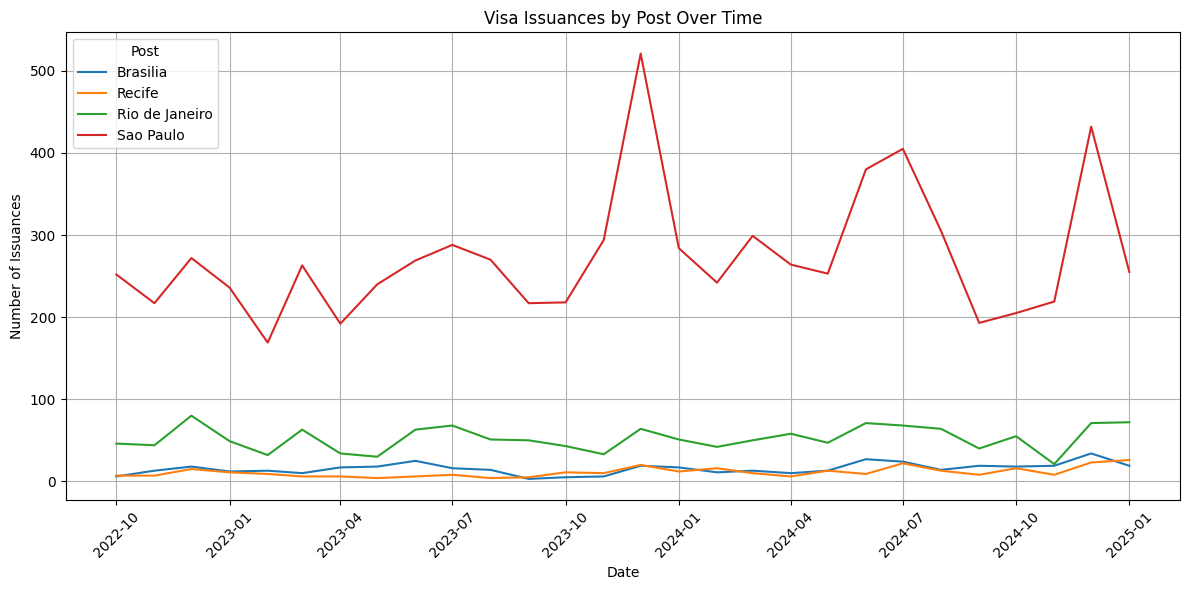

In [ ]:
import matplotlib.pyplot as plt

cols = ["Post", "Issuances", "Date"]
df_plot = df_filter2[cols].reset_index(drop=True)
df_plot['Date'] = pd.to_datetime(df_plot['Date'], format='%B %Y')



# df_plot
# df_filter2.plot(kind="line")
# Create the plot
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
for post in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[post], label=post)

plt.xlabel("Date")
plt.ylabel("Number of Issuances")
plt.title("Visa Issuances by Post Over Time")
plt.legend(title="Post")
plt.grid(True)  # Add a grid for better readability
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()    

In [123]:
sourceData = [
            {"code":"AF","value":"Afghanistan","vwp":false,"tt":false},
            {"code":"AL","value":"Albania","vwp":false,"tt":true},
            {"code":"AG","value":"Algeria","vwp":false,"tt":false},
            {"code":"AN","value":"Andorra","vwp":true,"tt":false},
            {"code":"AO","value":"Angola","vwp":false,"tt":false},
            {"code":"AV","value":"Anguilla","vwp":false,"tt":false},
            {"code":"AC","value":"Antigua and Barbuda","vwp":false,"tt":false},
            {"code":"AR","value":"Argentina","vwp":false,"tt":true},
            {"code":"AM","value":"Armenia","vwp":false,"tt":true},
            {"code":"AA","value":"Aruba","vwp":false,"tt":false},
            {"code":"A4","value":"Ascension Island","vwp":false,"tt":false},
            {"code":"AS","value":"Australia","vwp":true,"tt":true},
            {"code":"AU","value":"Austria","vwp":true,"tt":true},
            {"code":"AJ","value":"Azerbaijan","vwp":false,"tt":true},
            {"code":"BF","value":"Bahamas","vwp":false,"tt":false},
            {"code":"BA","value":"Bahrain","vwp":false,"tt":true},
            {"code":"BG","value":"Bangladesh","vwp":false,"tt":true},
            {"code":"BB","value":"Barbados","vwp":false,"tt":false},
            {"code":"BO","value":"Belarus","vwp":false,"tt":false},
            {"code":"BE","value":"Belgium","vwp":true,"tt":true},
            {"code":"BH","value":"Belize","vwp":false,"tt":false},
            {"code":"BN","value":"Benin","vwp":false,"tt":false},
            {"code":"BD","value":"Bermuda","vwp":false,"tt":false},
            {"code":"BT","value":"Bhutan","vwp":false,"tt":false},
            {"code":"BL","value":"Bolivia","vwp":false,"tt":true},
            {"code":"BK","value":"Bosnia and Herzegovina","vwp":false,"tt":true},
            {"code":"BC","value":"Botswana","vwp":false,"tt":false},
            {"code":"BR","value":"Brazil","vwp":false,"tt":false},
            {"code":"BX","value":"Brunei","vwp":true,"tt":true},
            {"code":"BU","value":"Bulgaria","vwp":false,"tt":true},
            {"code":"UV","value":"Burkina Faso","vwp":false,"tt":false},
            {"code":"BM","value":"Burma","vwp":false,"tt":false},
            {"code":"BY","value":"Burundi","vwp":false,"tt":false},
            {"code":"CB","value":"Cambodia","vwp":false,"tt":false},
            {"code":"CM","value":"Cameroon","vwp":false,"tt":true},
            {"code":"CA","value":"Canada","official":"Canada","vwp":false,"tt":true},
            {"code":"CA","value":"North Pole","official":"Canada","vwp":false,"tt":true},
            {"code":"CV","value":"Cabo Verde (formerly Cape Verde)","vwp":false,"tt":false},
            {"code":"CJ","value":"Cayman Islands","vwp":false,"tt":false},
            {"code":"CT","value":"Central African Republic","vwp":false,"tt":false},
            {"code":"CD","value":"Chad","vwp":false,"tt":false},
            {"code":"CI","value":"Chile","vwp":true,"tt":true},
            {"code":"CH","value":"China","vwp":false,"tt":false},
            {"code":"CO","value":"Colombia","vwp":false,"tt":true},
            {"code":"CN","value":"Comoros","vwp":false,"tt":false},
            {"code":"CF","value":"Congo, Democratic Republic of the","vwp":false,"tt":true},
            {"code":"CG","value":"Congo, Republic of the","vwp":false,"tt":true},
            {"code":"CS","value":"Costa Rica","vwp":false,"tt":true},
            {"code":"IV","value":"Cote d' Ivoire","official":"Cote d' Ivoire","vwp":false,"tt":false},
            {"code":"IV","value":"Cote d Ivoire","official":"Cote d' Ivoire","vwp":false,"tt":false},
            {"code":"IV","value":"Ivory Coast","official":"Cote d' Ivoire","vwp":false,"tt":false},
            {"code":"HR","value":"Croatia","vwp":true,"tt":true},
            {"code":"CU","value":"Cuba","vwp":false,"tt":false},
            {"code":"UC","value":"Curacao","vwp":false,"tt":false},
            {"code":"CY","value":"Cyprus","vwp":false,"tt":false},
            {"code":"EZ","value":"Czech Republic","vwp":true,"tt":true},
            {"code":"DA","value":"Denmark","vwp":true,"tt":true},
            {"code":"DJ","value":"Djibouti","vwp":false,"tt":false},
            {"code":"DO","value":"Dominica","vwp":false,"tt":false},
            {"code":"DR","value":"Dominican Republic","vwp":false,"tt":false},
            {"code":"EC","value":"Ecuador","vwp":false,"tt":true},
            {"code":"EG","value":"Egypt","vwp":false,"tt":true},
            {"code":"ES","value":"El Salvador","vwp":false,"tt":false},
            {"code":"EK","value":"Equatorial Guinea","vwp":false,"tt":false},
            {"code":"ER","value":"Eritrea","vwp":false,"tt":false},
            {"code":"EN","value":"Estonia","vwp":true,"tt":true},
            {"code":"WZ","value":"Eswatini","vwp":false,"tt":false},            
            {"code":"ET","value":"Ethiopia","vwp":false,"tt":true},
            {"code":"FJ","value":"Fiji","vwp":false,"tt":false},
            {"code":"FI","value":"Finland","vwp":true,"tt":true},
            {"code":"FR","value":"France","vwp":true,"tt":true},
            {"code":"GB","value":"Gabon","vwp":false,"tt":false},
            {"code":"GA","value":"Gambia, The","vwp":false,"tt":false},
            {"code":"GG","value":"Georgia","vwp":false,"tt":true},
            {"code":"GM","value":"Germany","vwp":true,"tt":true},
            {"code":"GH","value":"Ghana","vwp":false,"tt":false},
            {"code":"GI","value":"Gibraltar","vwp":false,"tt":false},
            {"code":"GR","value":"Greece","vwp":true,"tt":true},
            {"code":"GJ","value":"Grenada","vwp":false,"tt":true},
            {"code":"GT","value":"Guatemala","vwp":false,"tt":false},
            {"code":"GV","value":"Guinea","vwp":false,"tt":false},
            {"code":"PU","value":"Guinea-Bissau","vwp":false,"tt":false},
            {"code":"GY","value":"Guyana","vwp":false,"tt":false},
            {"code":"HA","value":"Haiti","vwp":false,"tt":false},
            {"code":"VT","value":"Holy See (Vatican City)","vwp":false,"tt":false},
            {"code":"HO","value":"Honduras","vwp":false,"tt":true},
            {"code":"HK","value":"Hong Kong S.A.R.","vwp":false,"tt":false},
            {"code":"HU","value":"Hungary","vwp":true,"tt":false},
            {"code":"IC","value":"Iceland","vwp":true,"tt":false},
            {"code":"IN","value":"India","vwp":false,"tt":false},
            {"code":"ID","value":"Indonesia","vwp":false,"tt":false},
            {"code":"IR","value":"Iran","vwp":false,"tt":true},
            {"code":"IZ","value":"Iraq","vwp":false,"tt":false},
            {"code":"EI","value":"Ireland","vwp":true,"tt":true},
            {"code":"IS","value":"Israel","vwp":true,"tt":true},
            {"code":"IT","value":"Italy","vwp":true,"tt":true},
            {"code":"JM","value":"Jamaica","vwp":false,"tt":true},
            {"code":"JA","value":"Japan","vwp":true,"tt":true},
            {"code":"JO","value":"Jordan","vwp":false,"tt":true},
            {"code":"KZ","value":"Kazakhstan","vwp":false,"tt":true},
            {"code":"KE","value":"Kenya","vwp":false,"tt":false},
            {"code":"KR","value":"Kiribati","vwp":false,"tt":false},
            {"code":"KN","value":"Korea, North","vwp":false,"tt":false},
            {"code":"KS","value":"Korea, South","vwp":true,"tt":true},
            {"code":"KV","value":"Kosovo","vwp":false,"tt":true},
            {"code":"KU","value":"Kuwait","vwp":false,"tt":false},
            {"code":"KG","value":"Kyrgyzstan","vwp":false,"tt":true},
            {"code":"LA","value":"Laos","vwp":false,"tt":false},
            {"code":"LG","value":"Latvia","vwp":true,"tt":true},
            {"code":"LE","value":"Lebanon","vwp":false,"tt":false},
            {"code":"LT","value":"Lesotho","vwp":false,"tt":false},
            {"code":"LI","value":"Liberia","vwp":false,"tt":true},
            {"code":"LY","value":"Libya","vwp":false,"tt":false},
            {"code":"LS","value":"Liechtenstein","vwp":true,"tt":false},
            {"code":"LH","value":"Lithuania","vwp":true,"tt":true},
            {"code":"LU","value":"Luxembourg","vwp":true,"tt":true},
            {"code":"MC","value":"Macau S.A.R.","vwp":false,"tt":false},
            {"code":"MK","value":"North Macedonia","vwp":false,"tt":true},
            {"code":"MA","value":"Madagascar","vwp":false,"tt":false},
            {"code":"MI","value":"Malawi","vwp":false,"tt":false},
            {"code":"MY","value":"Malaysia","vwp":false,"tt":false},
            {"code":"MV","value":"Maldives","vwp":false,"tt":false},
            {"code":"ML","value":"Mali","vwp":false,"tt":false},
            {"code":"MT","value":"Malta","vwp":true,"tt":false},
            {"code":"RM","value":"Marshall Islands","vwp":false,"tt":false},
            {"code":"MR","value":"Mauritania","vwp":false,"tt":false},
            {"code":"MP","value":"Mauritius","vwp":false,"tt":false},
            {"code":"MX","value":"Mexico","vwp":false,"tt":true},
            {"code":"FM","value":"Micronesia","vwp":false,"tt":false},
            {"code":"MD","value":"Moldova","vwp":false,"tt":true},
            {"code":"MN","value":"Monaco","vwp":true,"tt":false},
            {"code":"MG","value":"Mongolia","vwp":false,"tt":true},
            {"code":"MJ","value":"Montenegro","vwp":false,"tt":true},
            {"code":"MH","value":"Montserrat","vwp":false,"tt":false},
            {"code":"MO","value":"Morocco","vwp":false,"tt":true},
            {"code":"MZ","value":"Mozambique","vwp":false,"tt":false},
            {"code":"WA","value":"Namibia","vwp":false,"tt":false},
            {"code":"NR","value":"Nauru","vwp":false,"tt":false},
            {"code":"NP","value":"Nepal","vwp":false,"tt":false},
            {"code":"NL","value":"Netherlands","vwp":true,"tt":true},
            {"code":"NC","value":"New Caledonia","vwp":false,"tt":false},
            {"code":"NZ","value":"New Zealand","vwp":true,"tt":false},
            {"code":"NU","value":"Nicaragua","vwp":false,"tt":false},
            {"code":"NG","value":"Niger","vwp":false,"tt":false},
            {"code":"NI","value":"Nigeria","vwp":false,"tt":false},
            {"code":"NO","value":"Norway","vwp":true,"tt":true},
            {"code":"MU","value":"Oman","vwp":false,"tt":true},
            {"code":"PK","value":"Pakistan","vwp":false,"tt":true},
            {"code":"PS","value":"Palau","vwp":false,"tt":false},
            {"code":"PAL","value":"Palestinian Authority","vwp":false,"tt":false},
            {"code":"PM","value":"Panama","vwp":false,"tt":true},
            {"code":"PP","value":"Papua New Guinea","vwp":false,"tt":false},
            {"code":"PA","value":"Paraguay","vwp":false,"tt":true},
            {"code":"PE","value":"Peru","vwp":false,"tt":false},
            {"code":"RP","value":"Philippines","vwp":false,"tt":true},
            {"code":"PC","value":"Pitcairn Islands","vwp":false,"tt":false},
            {"code":"PL","value":"Poland","vwp":true,"tt":true},
            {"code":"PO","value":"Portugal","vwp":true,"tt":false},
            {"code":"QA","value":"Qatar","vwp":true,"tt":false},
            {"code":"RO","value":"Romania","vwp":false,"tt":true},
            {"code":"RS","value":"Russia","vwp":false,"tt":false},
            {"code":"RW","value":"Rwanda","vwp":false,"tt":false},
            {"code":"SH","value":"Saint Helena","official":"Saint Helena","vwp":false,"tt":false},
            {"code":"SH","value":"St Helena","official":"Saint Helena","vwp":false,"tt":false},
            {"code":"SH","value":"St. Helena","official":"Saint Helena","vwp":false,"tt":false},
            {"code":"SC","value":"Saint Kitts and Nevis","official":"Saint Kitts and Nevis","vwp":false,"tt":false},
            {"code":"SC","value":"St. Kitts and Nevis","official":"Saint Kitts and Nevis","vwp":false,"tt":false},
            {"code":"SC","value":"St Kitts and Nevis","official":"Saint Kitts and Nevis","vwp":false,"tt":false},
            {"code":"ST","value":"Saint Lucia","official":"Saint Lucia","vwp":false,"tt":false},
            {"code":"ST","value":"St. Lucia","official":"Saint Lucia","vwp":false,"tt":false},
            {"code":"ST","value":"St Lucia","official":"Saint Lucia","vwp":false,"tt":false},
            {"code":"VC","value":"Saint Vincent and the Grenadines","official":"Saint Vincent and the Grenadines","vwp":false,"tt":false},
            {"code":"VC","value":"St Vincent and the Grenadines","official":"Saint Vincent and the Grenadines","vwp":false,"tt":false},
            {"code":"VC","value":"St. Vincent and the Grenadines","official":"Saint Vincent and the Grenadines","vwp":false,"tt":false},
            {"code":"WS","value":"Samoa","vwp":false,"tt":false},
            {"code":"SM","value":"San Marino","vwp":true,"tt":false},
            {"code":"TP","value":"Sao Tome and Principe","vwp":false,"tt":false},
            {"code":"SA","value":"Saudi Arabia","vwp":false,"tt":false},
            {"code":"SG","value":"Senegal","vwp":false,"tt":true},
            {"code":"RI","value":"Serbia","vwp":false,"tt":true},
            {"code":"SE","value":"Seychelles","vwp":false,"tt":false},
            {"code":"SL","value":"Sierra Leone","vwp":false,"tt":false},
            {"code":"SN","value":"Singapore","vwp":true,"tt":true},
            {"code":"NN","value":"Sint Maarten","official":"Sint Maarten","vwp":false,"tt":false},
            {"code":"NN","value":"Saint Maarten","official":"Sint Maarten","vwp":false,"tt":false},
            {"code":"NN","value":"St. Maarten","official":"Sint Maarten","vwp":false,"tt":false},
            {"code":"NN","value":"St Maarten","official":"Sint Maarten","vwp":false,"tt":false},
            {"code":"LO","value":"Slovakia","vwp":true,"tt":true},
            {"code":"SI","value":"Slovenia","vwp":true,"tt":true},
            {"code":"BP","value":"Solomon Islands","vwp":false,"tt":false},
            {"code":"SO","value":"Somalia","vwp":false,"tt":false},
            {"code":"SF","value":"South Africa","vwp":false,"tt":false},
            {"code":"OD","value":"South Sudan","vwp":false,"tt":false},
            {"code":"SP","value":"Spain","vwp":true,"tt":true},
            {"code":"CE","value":"Sri Lanka","vwp":false,"tt":true},
            {"code":"SU","value":"Sudan","vwp":false,"tt":false},
            {"code":"NS","value":"Suriname","vwp":false,"tt":true},
            {"code":"SW","value":"Sweden","vwp":true,"tt":true},
            {"code":"SZ","value":"Switzerland","vwp":true,"tt":true},
            {"code":"SY","value":"Syria","vwp":false,"tt":false},
            {"code":"TW","value":"Taiwan","vwp":true,"tt":true},
            {"code":"TI","value":"Tajikistan","vwp":false,"tt":false},
            {"code":"TZ","value":"Tanzania","vwp":false,"tt":false},
            {"code":"TH","value":"Thailand","vwp":false,"tt":true},
            {"code":"TT","value":"Timor-Leste","vwp":false,"tt":false},
            {"code":"TO","value":"Togo","vwp":false,"tt":true},
            {"code":"TN","value":"Tonga","vwp":false,"tt":false},
            {"code":"TD","value":"Trinidad and Tobago","vwp":false,"tt":true},
            {"code":"TS","value":"Tunisia","vwp":false,"tt":true},
            {"code":"TU","value":"Turkey","vwp":false,"tt":true},
            {"code":"TX","value":"Turkmenistan","vwp":false,"tt":false},
            {"code":"TK","value":"Turks and Caicos Islands","vwp":false,"tt":false},
            {"code":"TV","value":"Tuvalu","vwp":false,"tt":false},
            {"code":"UG","value":"Uganda","vwp":false,"tt":false},
            {"code":"UP","value":"Ukraine","vwp":false,"tt":true},
            {"code":"AE","value":"United Arab Emirates","vwp":false,"tt":false},
            {"code":"UK","value":"United Kingdom","vwp":true,"tt":true},
            {"code":"US","value":"United States","vwp":false,"tt":false},
            {"code":"UY","value":"Uruguay","vwp":false,"tt":false},
            {"code":"UZ","value":"Uzbekistan","vwp":false,"tt":false},
            {"code":"NH","value":"Vanuatu","vwp":false,"tt":false},
            {"code":"VE","value":"Venezuela","vwp":false,"tt":false},
            {"code":"VM","value":"Vietnam","vwp":false,"tt":false},
            {"code":"VI","value":"Virgin Islands, British","vwp":false,"tt":false},
            {"code":"WF","value":"Wallis and Futuna","vwp":false,"tt":false},
            {"code":"YM","value":"Yemen","vwp":false,"tt":false},
            {"code":"ZA","value":"Zambia","vwp":false,"tt":false},
            {"code":"ZI","value":"Zimbabwe","vwp":false,"tt":false}
        ]



Error: Could not find sourceData variable in the JavaScript file.
Failed to retrieve or process visa posts data.


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

url = "https://travel.state.gov/content/travel/en/us-visas/visa-information-resources/fees/visa-issuing-posts.html"

try:
    response = requests.get(url)
    response.raise_for_status()
except requests.exceptions.RequestException as e:
    print(f"Erro ao acessar a URL: {e}")
    exit()

soup = BeautifulSoup(response.content, 'html.parser')

# Busca menos restrita (mas ainda razoavelmente específica)
header = soup.find('h3', string=lambda text: text and "Reciprocity Visa Issuance" in text)

if header is None:
    print("Cabeçalho da tabela não encontrado.  Inspecione a página novamente.")  # Mensagem de erro mais clara
    exit()

# Encontrar a tabela.  O cabeçalho é seguido por um paragrafo e *depois* a tabela.
# Adicionando mais uma camada de defesa: se o <p> não estiver lá, procurar diretamente a tabela.
paragraph = header.find_next_sibling("p")
if paragraph:
    table = paragraph.find_next_sibling('table')
else:
    table = header.find_next_sibling("table")

if table is None:
    print("Tabela não encontrada. Inspecione a página novamente.")
    exit()


headers = []
for th in table.find_all('th'):
    headers.append(th.text.strip())

data = []
for row in table.find_all('tr'):
    row_data = []
    for cell in row.find_all('td'):
        row_data.append(cell.text.strip())
    if row_data:
        data.append(row_data)

df = pd.DataFrame(data, columns=headers)
print(df)
# df.to_csv('tabela_embaixadas.csv', index=False)
# df.to_excel('tabela_embaixadas.xlsx', index=False)

Cabeçalho da tabela não encontrado.  Inspecione a página novamente.


AttributeError: 'NoneType' object has no attribute 'find_next_sibling'

: 

In [ ]:
header